<h1 style="text-align:center">Data Science and Machine Learning Capstone Project</h1>
<img style="float:right" src="https://prod-edxapp.edx-cdn.org/static/edx.org/images/logo.790c9a5340cb.png">
<p style="text-align:center">IBM: DS0720EN</p>
<p style="text-align:center">Question 3 of 4</p>

1. [Problem Statement](#problem)
2. [Question 3](#question)
3. [Data Cleaning and Standardization](#wrangling)
4. [Analyzing and Visualizing](#analysis)
5. [Concluding Remarks](#conclusion)

<a id="problem"></a>
# Problem Statement
---

The people of New York use the 311 system to report complaints about the non-emergency problems to local authorities. Various agencies in New York are assigned these problems. The Department of Housing Preservation and Development of New York City is the agency that processes 311 complaints that are related to housing and buildings.

In the last few years, the number of 311 complaints coming to the Department of Housing Preservation and Development has increased significantly. Although these complaints are not necessarily urgent, the large volume of complaints and the sudden increase is impacting the overall efficiency of operations of the agency.

Therefore, the Department of Housing Preservation and Development has approached your organization to help them manage the large volume of 311 complaints they are receiving every year.

The agency needs answers to several questions. The answers to those questions must be supported by data and analytics. These are their  questions:

<a id="question"></a>
# Question 3
---

Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?

## Approach
Determine whether or not there are any correlations between the building characteristics of buildings that experienced HEAT/HOT WATER complaints (from Question 1) relative to the building characteristics of all buildings in the PLUTO house database.

## Load Data
Separately from this notebook:

The [New York 311](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) data was loaded by [SODA](https://data.cityofnewyork.us/resource/fhrw-4uyv.csv?$limit=100000000&Agency=HPD&$select=created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status) into a Pandas DataFrame then saved to a pickle file.

The [New York PLUTO](https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/xuk2-nczf) data was downloaded.  The instructions at ( Course / 1. Project Challenge Details and Setup / Datasets Used in this Course / Datasets ) said "Use only the part that is specific to the borough that you are interested in based on your analysis."  My answer for Question 2 suggested the borough with the biggest HEAT/HOT WATER problem was BRONX.  For that reason, only the BX_18v1.csv file was loaded into a Pandas DataFrame then saved to a pickle file

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import jaccard_score, classification_report, log_loss, confusion_matrix

files_path = 'C:\\Users\\It_Co\\Documents\\DataScience\\Capstone\\' #local
#files_path = './' #IBM Cloud / Watson Studio

In [2]:
b311 = pd.read_pickle(files_path + 'ny311full.pkl')

#file_columns = ['Address','BldgArea','BldgDepth','BuiltFAR','CommFAR','FacilFAR','Lot','LotArea','LotDepth','NumBldgs','NumFloors','OfficeArea','ResArea','ResidFAR','RetailArea','YearBuilt','YearAlter1','ZipCode', 'YCoord', 'XCoord']
#df = pd.read_csv(files_path + 'BX_18v1.csv', usecols=file_columns)
#df = pd.concat([df, pd.read_csv(files_path + 'BK_18v1.csv', usecols=file_columns)])
#df = pd.concat([df, pd.read_csv(files_path + 'MN_18v1.csv', usecols=file_columns)])
#df = pd.concat([df, pd.read_csv(files_path + 'QN_18v1.csv', usecols=file_columns)])
#df = pd.concat([df, pd.read_csv(files_path + 'SI_18v1.csv', usecols=file_columns)])
#df.to_pickle(files_path + 'q3.pkl')

df = pd.read_pickle(files_path + 'q3.pkl')

print("NY 311 shape %s" % (b311.shape,))
print("PLUTO shape %s" % (df.shape,))

NY 311 shape (5862383, 15)
PLUTO shape (89854, 20)


<a id="wrangling"></a>
# Data Cleaning and Standardization
---

Correct or remove observations with missing or malformed data.  The 311 and the PLUTO data sets will need to be "joined" together by the common "address" element, which means the addresses will need to be standardized to a consistent layout to allow the addresses to be compared consistently.

## NY 311

### General

In [3]:
#Remove columns deemed unnecessary for this question.
b311.drop(['created_date','street_name','address_type','resolution_description','closed_date','location_type','status','unique_key','latitude','longitude'], axis=1, inplace=True)
#Only use the combined "heating and hot water" complaints determined from Question 1.
b311['complaint_type'] = b311['complaint_type'].str.upper()
b311.drop(b311[b311["complaint_type"].isin(["HEAT/HOT WATER","HEATING"])==False].index, axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
#Adjust all relevant strings to uppercase so different casing won't appear as separate values.
b311['incident_address'] = b311['incident_address'].str.upper()
b311['city'] = b311['city'].str.upper()
b311['borough'] = b311['borough'].str.upper()

In [4]:
#Print some initial information for comparison during later steps.
print("shape %s" % str(b311.shape))
print("--nulls below--")
print(b311.isnull().sum())
print("--types below--")
print(b311.dtypes)
b311.head()

shape (2040461, 5)
--nulls below--
complaint_type          0
incident_zip        18970
incident_address        1
city                18843
borough                 0
dtype: int64
--types below--
complaint_type       object
incident_zip        float64
incident_address     object
city                 object
borough              object
dtype: object


,complaint_type,incident_zip,incident_address,city,borough
0,HEAT/HOT WATER,11233.0,1711 FULTON STREET,BROOKLYN,BROOKLYN
1,HEAT/HOT WATER,10457.0,4487 3 AVENUE,BRONX,BRONX
2,HEAT/HOT WATER,11204.0,6802 18 AVENUE,BROOKLYN,BROOKLYN
3,HEAT/HOT WATER,10031.0,620 WEST 141 STREET,NEW YORK,MANHATTAN
4,HEAT/HOT WATER,10032.0,527 WEST 162 STREET,NEW YORK,MANHATTAN


### Standardize Borough
Leveraging findings found while standardizing during Question 2.

In [5]:
b311['borough'].value_counts()

BRONX            569960
BROOKLYN         543166
MANHATTAN        398552
UNSPECIFIED      282917
QUEENS           228447
STATEN ISLAND     17419
Name: borough, dtype: int64

In [6]:
#Correct rows where borough was entered in the city column with "UNSPECIFIED" in the borough column.
five_boroughs = ["BROOKLYN","BRONX","MANHATTAN","QUEENS","STATEN ISLAND"]
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isin(five_boroughs)].index
b311.loc[which_rows_to_adjust,'borough']=b311.loc[which_rows_to_adjust,'city']
b311.loc[which_rows_to_adjust,'city']=np.nan
#Drop a few rows of ambiguous data.
b311.drop(b311[(b311["borough"]=='MANHATTAN')&(b311["city"]=='BRONX')].index, axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
#Fill in UNSPECIFIED borough when city was entered as NEW YORK.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&(b311["city"]=='NEW YORK')].index
b311.loc[which_rows_to_adjust,'borough']="MANHATTAN"
b311.loc[which_rows_to_adjust,'city']=np.nan
#Although the city for most of the "NEW YORK" ones are the only ones that technically got the "city" column valued correctly,
#since every other row uses city as "neighborhood":  Standardize these.
which_rows_to_adjust = b311[(b311["city"]=='NEW YORK')].index
b311.loc[which_rows_to_adjust,'city']=np.nan
#Any still unspecified boroughs with a value in "city" are in the Queens borough.  The "city" is actually a "neighborhood".
queens_neighborhoods = b311[(b311['borough']=='UNSPECIFIED')&(b311['city'].isnull()==False)]['city'].unique()
#Standardize borough for Queens neighborhoods.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isin(queens_neighborhoods)].index
b311.loc[which_rows_to_adjust,'borough']="QUEENS"
#Null the borough if it still shows up as unspecified borough as there is no other information from which to derive it.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isnull()].index
b311.loc[which_rows_to_adjust,'borough']=np.nan

In [7]:
b311['borough'].value_counts()

BRONX            658545
BROOKLYN         636554
MANHATTAN        457638
QUEENS           266565
STATEN ISLAND     20881
Name: borough, dtype: int64

### Filter NY 311 data by borough to only include BRONX
The instructions at ( Course / 1. Project Challenge Details and Setup / Datasets Used in this Course / Datasets ) said "Use only the part that is specific to the borough that you are interested in based on your analysis."  My answer for Question 2 suggested the borough with the biggest HEAT/HOT WATER problem was BRONX.  For that reason, I am only considering the BRONX data.

In [8]:
b311.drop(b311[(b311["borough"]!='BRONX')].index, axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
b311['borough'].value_counts()

BRONX    658545
Name: borough, dtype: int64

### Remove unnecessary columns
These were only necessary to standardize and then filter by borough.

In [9]:
#Remove columns no longer necessary
b311.drop(['borough','city'], axis=1, inplace=True)
print(b311.shape)
print(b311.isnull().sum())
b311.head(3)

(658545, 3)
complaint_type         0
incident_zip        5957
incident_address       1
dtype: int64


,complaint_type,incident_zip,incident_address
0,HEAT/HOT WATER,10457.0,4487 3 AVENUE
1,HEAT/HOT WATER,10467.0,3414 KNOX PLACE
2,HEAT/HOT WATER,10473.0,2025 SEWARD AVENUE


In [10]:
# Drop observations with missing address as there will be no way to tie them to any PLUTO data.
b311.dropna(subset=['incident_address'], axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
print(b311.isnull().sum())
b311['incident_address'].value_counts().head()

complaint_type         0
incident_zip        5956
incident_address       0
dtype: int64


3810 BAILEY AVENUE          7112
1025 BOYNTON AVENUE         5773
2090 EAST TREMONT AVENUE    3748
888 GRAND CONCOURSE         3211
2968 PERRY AVENUE           2830
Name: incident_address, dtype: int64

## BRONX PLUTO

In [11]:
print("shape %s" % str(df.shape))
print("---isnull follows---")
print(df.isnull().sum())
df.head()

shape (89854, 20)
---isnull follows---
Lot              0
ZipCode        329
Address         69
LotArea          0
BldgArea         0
ResArea          0
OfficeArea       0
RetailArea       0
NumBldgs         0
NumFloors        0
LotDepth         0
BldgDepth        0
YearBuilt        0
YearAlter1       0
BuiltFAR         0
ResidFAR         0
CommFAR          0
FacilFAR         0
XCoord        3259
YCoord        3259
dtype: int64


,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
0,1,10454.0,122 BRUCKNER BOULEVARD,15000,0,0,0,0,1,0.0,200.0,0.0,0,0,0.00,6.02,5.0,6.5,1005957.0,232162.0
1,4,10454.0,126 BRUCKNER BOULEVARD,13770,752,0,272,0,2,1.0,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0
2,10,10454.0,138 BRUCKNER BOULEVARD,35000,39375,0,0,0,1,2.0,200.0,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0
3,17,10454.0,144 BRUCKNER BOULEVARD,2500,12500,12500,0,0,1,5.0,100.0,85.0,1931,2001,5.00,6.02,5.0,6.5,1006299.0,232033.0
4,18,10454.0,148 BRUCKNER BOULEVARD,1875,8595,6876,0,1719,1,5.0,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0


### General

In [12]:
df.dtypes

Lot             int64
ZipCode       float64
Address        object
LotArea         int64
BldgArea        int64
ResArea         int64
OfficeArea      int64
RetailArea      int64
NumBldgs        int64
NumFloors     float64
LotDepth      float64
BldgDepth     float64
YearBuilt       int64
YearAlter1      int64
BuiltFAR      float64
ResidFAR      float64
CommFAR       float64
FacilFAR      float64
XCoord        float64
YCoord        float64
dtype: object

In [13]:
#Adjust relevant strings to uppercase so different casing won't appear as separate values.
df['Address'] = df['Address'].str.upper()

In [14]:
# Drop the observations with missing address as there will be no way to tie them to any 311 data.
df.dropna(subset=['Address'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

## Standardization of Addresses
Leveraging standardization methods developed during question 2.

In [15]:
print("BRONX 311 unique addresses: %s" % b311['incident_address'].unique().size)
print("BRONX PLUTO unique addresses: %s" % df['Address'].unique().size)

BRONX 311 unique addresses: 23690
BRONX PLUTO unique addresses: 87017


<p style="color:Red;">Determine how much overlap.  Ideally all 29K BRONX 311 addresses will be represented in the PLUTO set.</p>

In [16]:
def WhichAddressesNotInPluto(howManyTopToShow):
    complaints = set(b311['incident_address'].unique())
    pluto = set(df['Address'].unique())
    #Determine which 311 addresses were not found in PLUTO to gain insight as to why.
    differences = complaints.difference(pluto)
    print("Records not in PLUTO: %s.  Percent: %s" % (len(differences), "{:.2%}".format(len(differences) / len(complaints))))
    print("---Top %i---" % howManyTopToShow)
    print(b311[b311['incident_address'].isin(differences)]['incident_address'].value_counts().head(howManyTopToShow))

In [17]:
WhichAddressesNotInPluto(3)

Records not in PLUTO: 5335.  Percent: 22.52%
---Top 3---
2090 EAST TREMONT AVENUE         3748
266 BEDFORD PARK BOULEVARD       2527
1425 DR M L KING JR BOULEVARD    2283
Name: incident_address, dtype: int64


<p style="color:Red;">Over 20 percent of addresses in the BRONX 311 data cannot be merged to the BRONX PLUTO data prior to standardization.</p>

### Borrow some python functions developed during question 2
With minor improvements to better work with full addresses instead of just street names.

In [18]:
# Some street values have multiple spaces in a row.
import re
def standardize_spaces(raw):
    result = raw.strip() #Remove leading and trailing spaces.
    result = re.sub(' +', ' ', result) #Squeeze multiple adjacent spaces into just one space.
    return result

In [19]:
# Some streets have problematic characters.  For example:  ST. ANN'S AVENUE also exists without period or apostophe.
problem_characters = ['.', '\'']
def replace_problem_characters(raw):
    result = raw
    for (character) in problem_characters:
        result = result.replace(character,'')
    return result

In [20]:
#Some words are sometimes entered in a non-standard way or with typos need to be standardized.
word_replacements = [("AVE","AVENUE"),("ST","STREET"),("RD","ROAD"),("FT","FORT"),("BX","BRONX"),("MT","MOUNT"),
                     ("NICHLAS","NICHOLAS"),("NICHALOS","NICHOLAS"),("EXPRE","EXPRESSWAY"),("HARACE","HORACE"),
                     ("NO","NORTH"),("AV","AVENUE"),("CRK","CREEK"),("FR","FATHER"),("JR","JUNIOR"),("GR","GRAND"),
                     ("CT","COURT"),
                     ("SR",""), # Service Road.  These are always near a similarly named street.  Lump together.
                     ("QN","QUEENS"),
                     ("ND",""), # A space between a number and ND such as EAST 52 ND STREET.  Note ST and RD can be street or road.
                     ("PO","POND"),("BO","BOND"),("GRA","GRAND"),("REV","REVEREND"),("CO-OP","COOP"),
                     ("GRANDCONCOURSE", "GRAND CONCOURSE"),("CENTRL", "CENTRAL"),("BLVD","BOULEVARD"),
                     ("FREDRICK", "FREDERICK"),("DOUGLAS", "DOUGLASS"),("MALCOM", "MALCOMN"),
                     ("NORTHEN", "NORTHERN"),("AVNEUE","AVENUE"),
                    ("N","NORTH"),("S","SOUTH"),("E","EAST"),("W","WEST"),("SW","SOUTHWEST"),
                             ("NW","NORTHWEST"),("SE","SOUTHEAST"),("NE","NORTHEAST")]
def replace_words(raw):
    split_raw = raw.split()
    for (old, new) in word_replacements:
        found_at_index = next((i for i, x in enumerate(split_raw) if x==old), None)
        if found_at_index!=None:
            split_raw[found_at_index] = new
    return standardize_spaces(" ".join(split_raw))

In [21]:
#Some words are actually prefixes of the following word.  Example the LA prefix of LA GRANGE.
word_prefixes = ["DE","MC","LA","VAN","MAC","CO"]
def concatenate_prefixes(raw):
    split_raw = raw.split()
    last_word = len(split_raw) - 1
    for (prefix) in word_prefixes:
        found_at_index = next((i for i, x in enumerate(split_raw) if x==prefix), None)
        if found_at_index!=None:
            if len(split_raw)>1:
                if found_at_index != last_word:
                    split_raw[found_at_index] = ''
                    split_raw[found_at_index+1] = prefix + split_raw[found_at_index+1]
                    return standardize_spaces(" ".join(split_raw))
    return raw

In [22]:
#Some phrases need custom replacement because they involve multiple words or easily mis-interpretted out of context.
phrase_replacements = [("DR M L KING JR","MARTIN LUTHER KING"),("DR MARTIN L KING","MARTIN LUTHER KING"),
    ("MARTIN LUTHER KING","MARTIN LUTHER KING"),("MARTIN L KING JR","MARTIN LUTHER KING"),
    ("MARTIN L KING","MARTIN LUTHER KING"),("ST NICHOLAS","SAINT NICHOLAS"),("ST JOHN","SAINT JOHN"),
    ("ST MARK","SAINT MARK"),("ST ANN","SAINT ANN"),("ST LAWRENCE","SAINT LAWRENCE"),("ST PAUL","SAINT PAUL"),
    ("ST PETER","SAINT PETER"),("ST RAYMOND","SAINT RAYMOND"),("ST THERESA","SAINT THERESA"),("ST FELIX","SAINT FELIX"),
    ("ST MARY","SAINT MARY"),("ST OUEN","SAINT OUEN"),("ST JAMES","SAINT JAMES"),("ST GEORGE","SAINT GEORGE"),
    ("ST EDWARD","SAINT EDWARD"),("ST CHARLES","SAINT CHARLES"),("ST FRANCIS","SAINT FRANCIS"),
    ("ST ANDREW","SAINT ANDREW"),("ST JUDE","SAINT JUDE"),("ST LUKE","SAINT LUKE"),("ST JOSEPH","SAINT JOSEPH"),
    ("N D PERLMAN","NATHAN PERLMAN"),("O BRIEN","OBRIEN"),("F D R","FDR"),("EXPRESSWAY N SR","EXPRESSWAY SR N"),
    ("HOR HARDING","HORACE HARDING"),
    ("SERVICE ROAD",""), # These are always near a similarly named street. Lump together.
    ("DUMMY",""),("ADAM C POWELL","ADAM CLAYTON POWELL"),("POWELL COVE","POWELLS COVE")]
def replace_phrases(raw):
    result = raw
    for (old,new) in phrase_replacements:
        result = standardize_spaces(result.replace(old,new))
    return result

In [23]:
# 1ST, 2ND, 3RD, 4TH, ... nTH
# Remove the suffixes leaving the numbers by themselves.
number_suffixes = ["ST","ND","RD","TH"]
digits=["1","2","3","4","5","6","7","8","9","0"]
def remove_number_suffixes(raw):
    split_raw = raw.split()
    for suffix in number_suffixes:
        found_at_index = next((i for i, x in enumerate(split_raw) if x[0] in digits and x.endswith(suffix)), None) 
        if found_at_index!=None:            
            split_raw[found_at_index] = split_raw[found_at_index][:-2]
            return standardize_spaces(" ".join(split_raw))
    return raw

In [24]:
def standardize_street(street):
    r = street 
    r = standardize_spaces(r) 
    r = replace_problem_characters(r) 
    r = replace_phrases(r) 
    r = replace_words(r) 
    r = concatenate_prefixes(r) 
    r = remove_number_suffixes(r) 
    return r

### Standardize the address in both the 311 and PLUTO data

In [25]:
b311['incident_address'] = b311['incident_address'].apply(standardize_street)

In [26]:
df['Address'] = df['Address'].apply(standardize_street)

In [27]:
# See if there was an improvement in how well the 311 data can be merged with the PLUTO data by address.
WhichAddressesNotInPluto(3)

Records not in PLUTO: 2436.  Percent: 11.24%
---Top 3---
2090 EAST TREMONT AVENUE             3748
1425 MARTIN LUTHER KING BOULEVARD    2283
223 NAPLES TERRACE                   1119
Name: incident_address, dtype: int64


<p style="color:Red;">The percentage of addresses in the 311 data that can be matched to an entry in the PLUTO data set improved measurably.</p>

In [28]:
#Save the file to more quickly repeat additional work below.
df.to_pickle(files_path + 'q3clean.pkl')

## Add variable to indicate how many HEAT complaints at each address.
So that we can see if it correlates to anything else in the data.

In [29]:
df = pd.read_pickle(files_path + 'q3clean.pkl')

In [30]:
#How many complaints at the address?
counts = b311['incident_address'].value_counts(sort=False).sort_index()
df['Complaints'] = df['Address'].map(counts)
df['Complaints'].replace(to_replace=np.nan, value=0, inplace=True)

In [31]:
#del b311 # Maybe save a little memory later

In [32]:
print (df.shape)
df['Complaints'].value_counts().head()

(89785, 21)


0.0    70520
1.0     4874
2.0     2285
3.0     1380
4.0     1012
Name: Complaints, dtype: int64

In [33]:
#Convert each unique address into a unique number.
#A category with a lot of different values, not a continuous value.
address_lookup = {k:v + 1 for v, k in enumerate(df['Address'].unique().tolist())}
df["Address"] = df["Address"].map(address_lookup)
len(df)

89785

In [34]:
#Save the file to more quickly repeat additional work below.
df.to_pickle(files_path + 'q3clean.pkl')

<p style="color:Red;">Saving the data allows restarting from this point without needing to wait for standardization of addresses and other time to be repeated as work continues.</p>

## Imputation
Handling "missing" features.  That are null or have a zero placeholder instead of a "real" value.

In [35]:
df = pd.read_pickle(files_path + 'q3clean.pkl')

In [36]:
def check_nulls():
    for col in df.columns:
        nulls = len(df[df[col].isnull()])
        if nulls > 0:
            print("%s:  %i of %i (%s)" % (col, nulls, df.shape[0], "{:.2%}".format(nulls / df.shape[0])))
check_nulls()

ZipCode:  263 of 89785 (0.29%)
XCoord:  3190 of 89785 (3.55%)
YCoord:  3190 of 89785 (3.55%)


In [37]:
#Replace with zeroes to kick these forward to the next section.
df['ZipCode'].replace(to_replace=np.nan, value=0, inplace=True)
df['XCoord'].replace(to_replace=np.nan, value=0, inplace=True)
df['YCoord'].replace(to_replace=np.nan, value=0, inplace=True)
check_nulls()

In [38]:
def check_zeroes():
    for col in df.columns:
        zeroes = len(df[df[col].eq(0)])
        if zeroes > 0:
            print("%s:  %i of %i (%s)" % (col, zeroes, df.shape[0], "{:.2%}".format(zeroes / df.shape[0])))
check_zeroes()

ZipCode:  263 of 89785 (0.29%)
LotArea:  234 of 89785 (0.26%)
BldgArea:  6355 of 89785 (7.08%)
ResArea:  14419 of 89785 (16.06%)
OfficeArea:  87250 of 89785 (97.18%)
RetailArea:  83893 of 89785 (93.44%)
NumBldgs:  6002 of 89785 (6.68%)
NumFloors:  6480 of 89785 (7.22%)
LotDepth:  192 of 89785 (0.21%)
BldgDepth:  6618 of 89785 (7.37%)
YearBuilt:  6299 of 89785 (7.02%)
YearAlter1:  81843 of 89785 (91.15%)
BuiltFAR:  6452 of 89785 (7.19%)
ResidFAR:  4295 of 89785 (4.78%)
CommFAR:  83764 of 89785 (93.29%)
FacilFAR:  1042 of 89785 (1.16%)
XCoord:  3190 of 89785 (3.55%)
YCoord:  3190 of 89785 (3.55%)
Complaints:  70520 of 89785 (78.54%)


In [39]:
# Drop rows that have only a small number of zero values in a column.
df.drop(df[df["ZipCode"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["LotArea"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["LotDepth"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["BldgDepth"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["BuiltFAR"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["FacilFAR"].eq(0)].index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
check_zeroes()

ResArea:  7463 of 82449 (9.05%)
OfficeArea:  80067 of 82449 (97.11%)
RetailArea:  76654 of 82449 (92.97%)
NumBldgs:  61 of 82449 (0.07%)
NumFloors:  114 of 82449 (0.14%)
YearBuilt:  7 of 82449 (0.01%)
YearAlter1:  74686 of 82449 (90.58%)
ResidFAR:  2441 of 82449 (2.96%)
CommFAR:  78220 of 82449 (94.87%)
XCoord:  248 of 82449 (0.30%)
YCoord:  248 of 82449 (0.30%)
Complaints:  63424 of 82449 (76.93%)


In [40]:
# May need to drop more rows, that had columns with a lot of zeroes in multiple columns.
df.drop(df[df["NumBldgs"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["NumFloors"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["YearBuilt"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["XCoord"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["YCoord"].eq(0)].index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
check_zeroes()

ResArea:  7284 of 82044 (8.88%)
OfficeArea:  79675 of 82044 (97.11%)
RetailArea:  76268 of 82044 (92.96%)
YearAlter1:  74331 of 82044 (90.60%)
ResidFAR:  2408 of 82044 (2.94%)
CommFAR:  77883 of 82044 (94.93%)
Complaints:  63065 of 82044 (76.87%)


<p style="color:Red;">Several features have a significant number of zeroes.  Some even a vast majority of zero values.  This means simply the fact that there was a zero or not could be an important thing to correlate.  I am going to create latent variables for each simply to record the presence of the value or not.  These latent variables can themselves be used to filter when doing regression checks on the root feature.  The latent variables themselves can even be the subject of regression checks.</p>

In [41]:
df.insert(len(df.columns) - 1, 'IsResArea', df['ResArea'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsOfficeArea', df['OfficeArea'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsRetailArea', df['RetailArea'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsYearAlter1', df['YearAlter1'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsResidFAR', df['ResidFAR'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsCommFAR', df['CommFAR'].ne(0).astype('int64'))

In [42]:
df.head()

,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,...,FacilFAR,XCoord,YCoord,IsResArea,IsOfficeArea,IsRetailArea,IsYearAlter1,IsResidFAR,IsCommFAR,Complaints
0,4,10454.0,2,13770,752,0,272,0,2,1.0,...,6.5,1006076.0,232156.0,0,1,0,1,1,1,0.0
1,10,10454.0,3,35000,39375,0,0,0,1,2.0,...,6.5,1006187.0,232036.0,0,0,0,0,1,1,0.0
2,17,10454.0,4,2500,12500,12500,0,0,1,5.0,...,6.5,1006299.0,232033.0,1,0,0,1,1,1,2.0
3,18,10454.0,5,1875,8595,6876,0,1719,1,5.0,...,6.5,1006363.0,232040.0,1,0,1,1,1,1,13.0
4,34,10454.0,7,8700,5316,0,0,0,2,1.0,...,6.5,1006046.0,232055.0,0,0,0,0,1,1,0.0


In [43]:
print(df['IsResArea'].value_counts())
print(df['IsOfficeArea'].value_counts())
print(df['IsRetailArea'].value_counts())
print(df['IsYearAlter1'].value_counts())
print(df['IsResidFAR'].value_counts())
print(df['IsCommFAR'].value_counts())

1    74760
0     7284
Name: IsResArea, dtype: int64
0    79675
1     2369
Name: IsOfficeArea, dtype: int64
0    76268
1     5776
Name: IsRetailArea, dtype: int64
0    74331
1     7713
Name: IsYearAlter1, dtype: int64
1    79636
0     2408
Name: IsResidFAR, dtype: int64
0    77883
1     4161
Name: IsCommFAR, dtype: int64


In [92]:
df['ResArea'].value_counts().sort_index()

0           7284
200            1
247            1
270            1
280            1
288            1
300            1
323            1
324            1
336            1
341            1
352            2
360            2
374            1
380            1
382            1
390            1
392            1
394            1
396            2
400            5
414            2
420            3
428            1
440            1
442            1
444            1
448            1
450            3
456            1
            ... 
631178         1
638539         1
653155         1
659606         1
665000         1
748000         1
750000         1
753113         1
758564         1
796368         1
799710         1
822400         1
862500         1
864200         1
868436         1
870740         1
905000         1
954414         1
963564         1
970383         1
972800         1
1073889        1
1151670        1
1162800        1
1197000        1
1306230        1
1478410        1
1539544       

## Scaling, Centering

In [44]:
df.columns

Index(['Lot', 'ZipCode', 'Address', 'LotArea', 'BldgArea', 'ResArea',
       'OfficeArea', 'RetailArea', 'NumBldgs', 'NumFloors', 'LotDepth',
       'BldgDepth', 'YearBuilt', 'YearAlter1', 'BuiltFAR', 'ResidFAR',
       'CommFAR', 'FacilFAR', 'XCoord', 'YCoord', 'IsResArea', 'IsOfficeArea',
       'IsRetailArea', 'IsYearAlter1', 'IsResidFAR', 'IsCommFAR',
       'Complaints'],
      dtype='object')

In [45]:
#Drop location and non-continual label columns
df.drop(['Lot','ZipCode','Address','XCoord','YCoord'], axis=1, inplace=True)

In [46]:
def scale_and_center(column_name):
    scale=MinMaxScaler()
    scale.fit(df[[column_name]])
    df[[column_name]]=scale.transform(df[[column_name]])
#scale_and_center('LotArea')
#scale_and_center('BldgArea')
#scale_and_center('NumBldgs')
#scale_and_center('NumFloors')
#scale_and_center('LotDepth')
#scale_and_center('BldgDepth')
#scale_and_center('YearBuilt')
#scale_and_center('BuiltFAR')
#scale_and_center('FacilFAR')
#scale_and_center('XCoord')
#scale_and_center('YCoord')

#for f in df.columns:
#    scale_and_center(f)

In [47]:
def scale_and_center_latent(column_name, latent):
    scale=MinMaxScaler()
    #scale.fit(df.loc[df[latent].eq(1), column_name].to_frame())
    df.loc[df[latent].eq(1), column_name] = scale.fit_transform(df.loc[df[latent].eq(1), column_name].to_frame())
#scale_and_center_latent('ResArea', 'IsResArea')
#scale_and_center_latent('OfficeArea', 'IsOfficeArea')
#scale_and_center_latent('RetailArea', 'IsRetailArea')
#scale_and_center_latent('YearAlter1', 'IsYearAlter1')
#scale_and_center_latent('ResidFAR', 'IsResidFAR')
#scale_and_center_latent('CommFAR', 'IsCommFAR')

In [48]:
df.describe()

,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,...,ResidFAR,CommFAR,FacilFAR,IsResArea,IsOfficeArea,IsRetailArea,IsYearAlter1,IsResidFAR,IsCommFAR,Complaints
count,8.204400e+04,8.204400e+04,8.204400e+04,8.204400e+04,82044.000000,82044.000000,82044.000000,82044.000000,82044.000000,82044.000000,...,82044.000000,82044.000000,82044.000000,82044.000000,82044.000000,82044.000000,82044.000000,82044.000000,82044.000000,82044.000000
mean,5.828139e+03,8.063525e+03,5.866987e+03,4.906857e+02,365.082882,1.246161,2.449325,103.220705,51.894344,1943.053410,...,1.688262,0.101856,2.864761,0.911218,0.028875,0.070401,0.094011,0.970650,0.050717,7.089976
std,4.475183e+04,5.877506e+04,5.342376e+04,1.060140e+04,4880.481128,1.401193,1.352179,41.712761,27.689994,29.334944,...,1.280098,0.518485,1.564359,0.284430,0.167455,0.255824,0.291845,0.168787,0.219420,57.567319
min,2.970000e+02,2.000000e+01,0.000000e+00,0.000000e+00,0.000000,1.000000,0.500000,10.000000,2.000000,1800.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.200000e+03,1.728000e+03,1.278000e+03,0.000000e+00,0.000000,1.000000,2.000000,95.000000,36.000000,1921.000000,...,0.900000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,2.500000e+03,2.329000e+03,1.888000e+03,0.000000e+00,0.000000,1.000000,2.000000,100.000000,46.000000,1935.000000,...,1.100000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,4.000000e+03,3.357000e+03,2.695250e+03,0.000000e+00,0.000000,1.000000,3.000000,101.420000,57.000000,1960.000000,...,2.430000,0.000000,4.800000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,5.612000e+06,1.354011e+07,1.321140e+07,1.311800e+06,598908.000000,251.000000,42.000000,2050.000000,992.000000,2017.000000,...,10.000000,9.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7112.000000


## Save the cleaned data.

In [49]:
df.to_pickle(files_path + 'q3clean.pkl')

<a id="analysis"></a>
# Analyzing and Visualizing
---

## Load combined and cleaned data

In [50]:
df = pd.read_pickle(files_path + 'q3clean.pkl')
print(df.shape[0])
print(len(df[df['Complaints'].ne(0)]))

82044
18979


## Analyze, using visualizations as necessary

### Regression and Residual plots
To measure correlation and correlation shape.

In [51]:
df.columns

Index(['LotArea', 'BldgArea', 'ResArea', 'OfficeArea', 'RetailArea',
       'NumBldgs', 'NumFloors', 'LotDepth', 'BldgDepth', 'YearBuilt',
       'YearAlter1', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR',
       'IsResArea', 'IsOfficeArea', 'IsRetailArea', 'IsYearAlter1',
       'IsResidFAR', 'IsCommFAR', 'Complaints'],
      dtype='object')

In [89]:
def RegressionAndResidual(feature, d): # Dataframe, possibly filtered
    #SCALE=StandardScaler(copy=True)
    #d[feature] = SCALE.fit_transform(d[[feature]])
    #d["Complaints"] = SCALE.fit_transform(d[["Complaints"]])
    fig = plt.figure() # create figure
    ax1 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
    ax2 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot).
    sns.regplot(x=feature, y="Complaints", data=d, ax=ax1)
    ax1.set_title(feature + ' Regression')
    sns.residplot(d[feature], d["Complaints"], ax=ax2)
    ax2.set_title ('Residual')
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    plt.show()

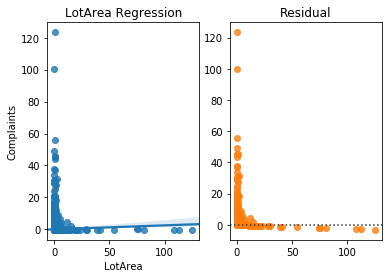

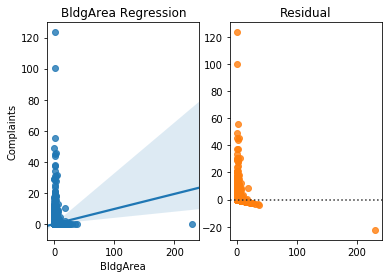

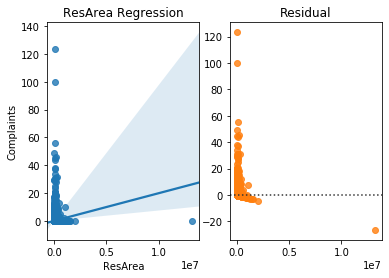

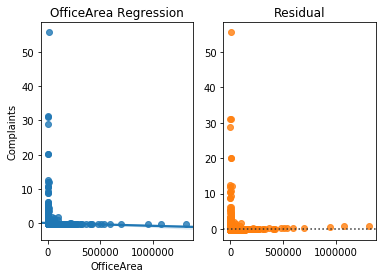

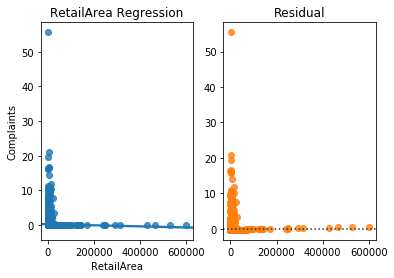

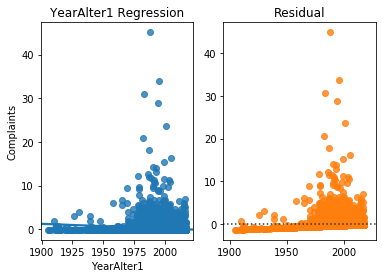

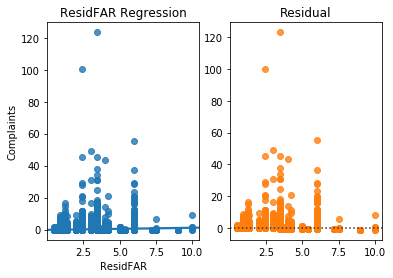

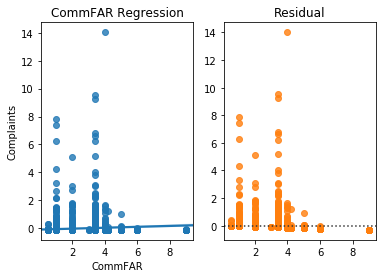

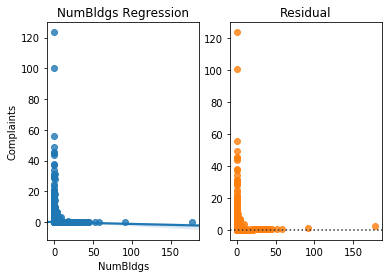

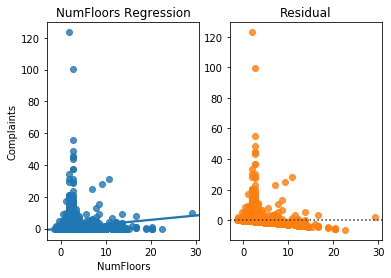

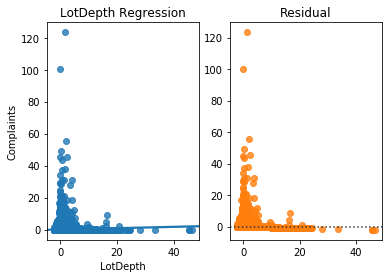

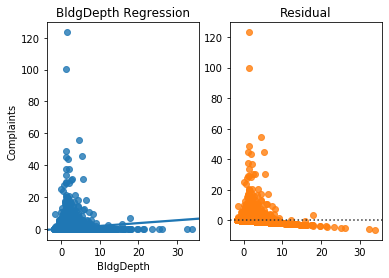

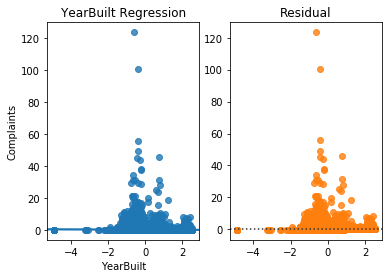

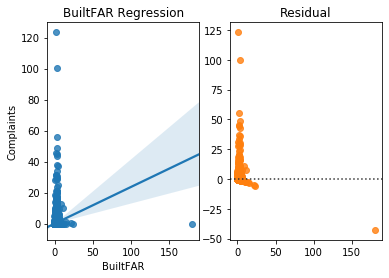

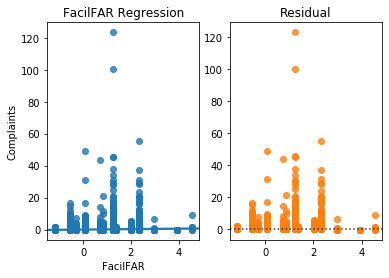

In [90]:
RegressionAndResidual("LotArea", df)
RegressionAndResidual("BldgArea", df)
RegressionAndResidual("ResArea", df[df['IsResArea'].ne(0)])
RegressionAndResidual("OfficeArea", df[df['IsOfficeArea'].ne(0)])
RegressionAndResidual("RetailArea", df[df['IsRetailArea'].ne(0)])
RegressionAndResidual("YearAlter1", df[df['IsYearAlter1'].ne(0)])
RegressionAndResidual("ResidFAR", df[df['IsResidFAR'].ne(0)])
RegressionAndResidual("CommFAR", df[df['IsCommFAR'].ne(0)])
RegressionAndResidual("NumBldgs", df)
RegressionAndResidual("NumFloors", df)
RegressionAndResidual("LotDepth", df)
RegressionAndResidual("BldgDepth", df)
RegressionAndResidual("YearBuilt", df)
RegressionAndResidual("BuiltFAR", df)
RegressionAndResidual("FacilFAR", df)

<p style="color:Red;">Most of the graphs are curved, suggesting non-linear relationships.</p>

### Pearson Correlation

In [58]:
# Check for correlations with heatmap.
AllForHeat = df.corr()
#AllForHeat.shape
AllForHeat.head()

,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,...,ResidFAR,CommFAR,FacilFAR,IsResArea,IsOfficeArea,IsRetailArea,IsYearAlter1,IsResidFAR,IsCommFAR,Complaints
LotArea,1.000000,0.615170,0.482160,0.336586,0.110371,0.488403,0.160414,0.493322,0.255314,0.017603,...,0.016300,0.041344,0.033102,-0.104623,0.103973,0.026487,0.074096,-0.048984,0.054362,0.024797
BldgArea,0.615170,1.000000,0.934357,0.234374,0.154978,0.614317,0.389971,0.363865,0.310811,0.019287,...,0.103847,0.043344,0.110809,-0.064864,0.105804,0.051741,0.103966,-0.020294,0.037685,0.096754
ResArea,0.482160,0.934357,1.000000,0.024822,0.049650,0.619655,0.378956,0.233395,0.175568,0.007873,...,0.095103,-0.007665,0.087757,0.034279,0.039170,0.029304,0.070810,0.014471,-0.012157,0.107567
OfficeArea,0.336586,0.234374,0.024822,1.000000,0.049065,0.080114,0.081869,0.261617,0.252565,0.014734,...,0.040636,0.066422,0.050218,-0.136086,0.268424,0.008423,0.062856,-0.026746,0.056511,-0.002492
RetailArea,0.110371,0.154978,0.049650,0.049065,1.000000,0.042415,0.011686,0.175593,0.242263,0.020925,...,0.062683,0.153935,0.083776,-0.172833,0.063900,0.271825,0.089130,-0.029385,0.122311,0.009099


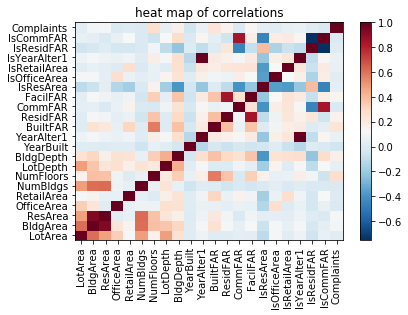

In [59]:
fig, ax = plt.subplots()
im = ax.pcolor(AllForHeat, cmap='RdBu_r')
row_labels = df.columns; col_labels = df.columns
ax.set_xticklabels(row_labels, minor = False);ax.set_yticklabels(col_labels, minor = False)
#move ticks and labels to the center.
ax.set_xticks(np.arange(AllForHeat.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(AllForHeat.shape[0]) + 0.5, minor=False)
ax.set_title("heat map of correlations")
plt.xticks(rotation=90)
plt.colorbar(im)
plt.show()

<p style="color:Red;">Looking along the top row or rightmost column, there appear to be some correlations, though none super strong.  Looking at the actual numbers might help see them better.</p>

In [60]:
#See numerically what the strongest correlations are.
AllForHeat[(AllForHeat['Complaints'].ge(0.05))|(AllForHeat['Complaints'].le(-0.05))]['Complaints'].sort_values(ascending=False)

Complaints      1.000000
NumFloors       0.272448
BuiltFAR        0.236182
BldgDepth       0.178435
ResidFAR        0.163001
FacilFAR        0.139918
ResArea         0.107567
BldgArea        0.096754
IsYearAlter1    0.067835
YearAlter1      0.067543
IsRetailArea    0.059201
Name: Complaints, dtype: float64

In [ ]:
# Get the pearson correlations and confidence measures
for col in df.columns:
    pearson_coef, p_value = stats.pearsonr(df[col], df['Complaints'])
    if abs(pearson_coef) > 0.20 and p_value < 0.10:
        print(col, pearson_coef, p_value)

<p style="color:Red;">Not really any "strong" correlations, but some weak ones with high confidence.  Double check the details of a few of these.</p>

In [ ]:
# Address correlates?  Why?
total = df.shape[0]
complainers = df[df['Complaints'].eq(1)].shape[0]
print (total, complainers, complainers / total)

<p style="color:Red;">I think address correlates just because each address either had a complaint or not, so the correlation is about the same as the percentage that had a complaint.  Also, question 2 already narrowed it down geographically so I'm going to dismiss this "correlation" as not relevant to the question at hand.  To a lesser extent the X Coordinate and ZIP code are in the same boat, though there may be a higher (but still very low) correlation than there is with address.</p>

In [ ]:
#YearAlter1 correlates?  Why?
total = df.shape[0]
never_altered = df[df['Complaints'].eq(0)].shape[0]
print (total, never_altered, never_altered / total)

In [ ]:
#Alteration year - take a closer look.
alterations = df[['YearAlter1','Complaints']]
alterations = pd.concat([alterations, pd.get_dummies(alterations['YearAlter1'])], axis=1)
for col in alterations.columns:
    pearson_coef, p_value = stats.pearsonr(alterations[col], alterations['Complaints'])
    if abs(pearson_coef) > 0.05 and p_value < 0.10:
        print(col, pearson_coef, p_value)

<p style="color:Red;">The only even mildly significant YearAlter1 correlations are between the observations where this field is zero, which is about 2/3 of the data.  My conclusion is that this is a factor of the high number of zeroes, causing the correlation to skew toward lower numbers, hence the lowest numbers, the zeroes themselves, are considered more correlated.</p>

In [ ]:
#check a few of these to see if they are different data points that capture the same relationship.
def see_pearson(a,b):
    pearson_coef, p_value = stats.pearsonr(df[a], df[b])
    print(a, b, pearson_coef, p_value)
see_pearson('ResidFAR','FacilFAR')
see_pearson('ResidFAR','BuiltFAR')
see_pearson('FacilFAR','BuiltFAR')

<p style="color:Red;">ResidFAR and FacilFAR are strongly correlated to each other.  The documentation says FAR is the "Floor Area Ratio" between the building and the LOT.  The Resid and Facility variations are about the same.  What they have in common is they are both "not commercial".</p>

#### Visualize strongest Pearson correlations

In [ ]:
#Visualize
#df.corr()['Complaints'].map(abs).plot(kind='bar', title='Correlation with heating complaints',figsize=(8,3))
df.corr()['Complaints'].plot(kind='bar', grid=True, title='Correlation with heating complaints',figsize=(8,3))
plt.xlabel('Building Characteristics'); plt.ylabel('Correlation')
plt.show()

<a id="conclusion"></a>
# Concluding Remarks
---

The HEATING/HOT WATER complaint types (Question 1) reported in the BRONX borough (question 2) have an obvious relationship with the following housing characteristics:
<ul>
<li>NumFloors (Number of Floors):  0.37 correlation.
<li>BuiltFAR (Total building floor area divided by the area of the tax lot):  0.35 correlation.
<li>ResidFAR ():  0.32 correlation.
</ul>
The inability to compute an effective logistic regression is further evidence that the relationships are not especially strong, but the pearson correlation confidence numbers suggest these measurements are accurate.

So basically the taller and bigger the floor area of the building, the more heating complaints from that building.  Especially residential buildings.